In [1]:
#Importation des librairies 
import umap
import umap.plot
from sklearn.cluster import DBSCAN
import warnings
import hdbscan
import seaborn as sns
from sklearn_extra.cluster import KMedoids
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from sklearn import decomposition
import numpy as np
import pandas as pd
import sklearn
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
# Pour les biplot
from bioinfokit.visuz import cluster
from IPython import display
import scipy.cluster.hierarchy as shc
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import  PowerTransformer
from scipy import stats
from sklearn.preprocessing import  QuantileTransformer
pt = PowerTransformer()
qt = QuantileTransformer(output_distribution='normal')
#import matplotlib.pyplot as plt3D
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', 100)
warnings.filterwarnings('ignore')
import datetime
sns.set(style='white', context='notebook', rc={'figure.figsize': (8, 6)})


Astuce UMAP pour l'utiliser comme entrée dans un modèle de clustering

Lorsque vous utilisez UMAP pour la réduction de dimension, vous souhaiterez sélectionner des paramètres différents de ceux que vous utiliseriez pour la visualisation. 
* Nous voudrons une  n_neighbors  valeur plus grande - les petites valeurs se concentreront davantage sur une structure très locale et sont plus susceptibles de produire une structure de cluster à grain fin qui peut être davantage le résultat de modèles de bruit dans les données que de clusters réels. Dans ce cas, nous allons le doubler de la valeur par défaut de 15 à 30.
* Deuxièmement, il est avantageux de définir min_dist  une valeur très faible. Étant donné que nous voulons en fait regrouper les points de manière dense(la densité est ce que nous voulons après tout), une valeur faible aidera, ainsi que des séparations plus nettes entre les clusters. Dans ce cas, nous allons simplement définir min_distà 0.

In [2]:
data_full = pd.read_csv(
    "/Users/anis/test_labnbook/test_3_indicateurs/comparaison/data.csv")
data_full.drop(["Unnamed: 0"], axis=1, inplace=True)
# Supprimer les labdocs ayant un score de contribution nul
#data_full.drop(index=data_full[data_full["indice_contrib"]
        #       == 0].index.values, axis=0, inplace=True)

#data_full.drop(["n_users", "n_modif",	"duree",  "n_mots"], axis=1, inplace=True)

data_full.drop(
    index=data_full[data_full["equi_contrib"] <= 0].index.values, inplace=True)
data_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16267 entries, 0 to 17506
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   id_labdoc     16267 non-null  int64  
 1   n_users       16267 non-null  int64  
 2   n_mots        16267 non-null  int64  
 3   collab        16267 non-null  float64
 4   equi_contrib  16267 non-null  float64
 5   n_modif       16267 non-null  int64  
 6   duree         16267 non-null  float64
 7   pass_main     16267 non-null  int64  
dtypes: float64(3), int64(5)
memory usage: 1.1 MB


In [3]:
data_full.head()

,id_labdoc,n_users,n_mots,collab,equi_contrib,n_modif,duree,pass_main
0,313544,3,67,0.086970,0.089902,13,1934637.0,3
1,325259,2,180,0.616471,0.947732,64,215938.0,1
2,313676,3,110,0.035226,0.036662,66,1818387.0,1
3,313555,3,152,0.066678,0.069033,9,1933760.0,1
4,312700,5,38,0.555177,0.555177,18,2278994.0,6


<AxesSubplot:>

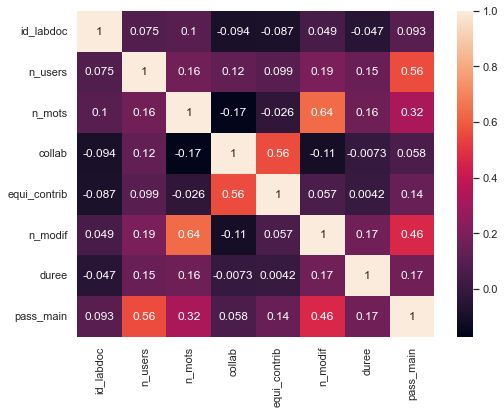

In [4]:
sns.heatmap(data_full.corr(),annot=True)

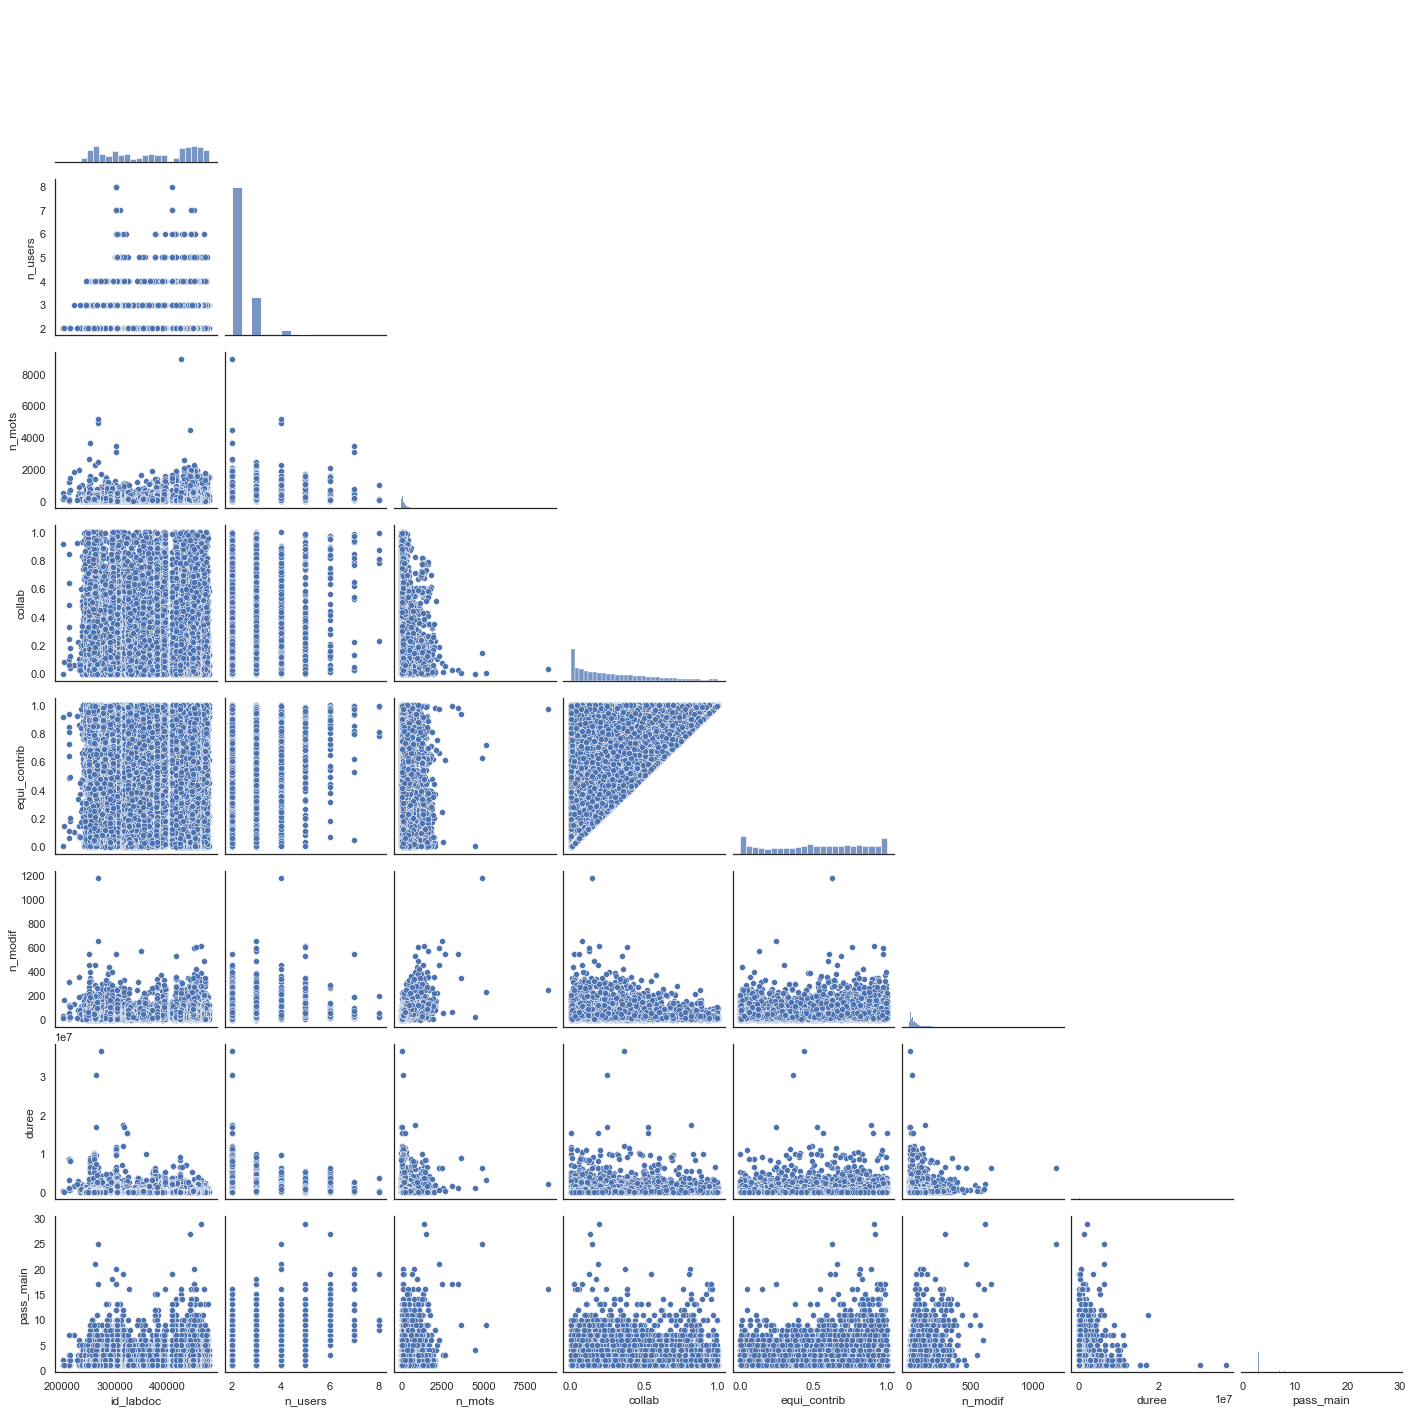

In [5]:
sns.pairplot(data_full,corner=True)

In [6]:
# J'enlève la variable n_users
X = data_full.copy()
X.drop(["n_users"], axis=1, inplace=True)
#X.index = np.array(data['id_labdoc'])
id_labdoc = data_full['id_labdoc']
X.drop(['id_labdoc'], axis=1, inplace=True)

# z_scores = stats.zscore(X)
# abs_z_scores = np.abs(z_scores)
# filtered_entries = (abs_z_scores < 3).all(axis=1)
# X = X[filtered_entries]
# X.info()

X.head()

,n_mots,collab,equi_contrib,n_modif,duree,pass_main
0,67,0.086970,0.089902,13,1934637.0,3
1,180,0.616471,0.947732,64,215938.0,1
2,110,0.035226,0.036662,66,1818387.0,1
3,152,0.066678,0.069033,9,1933760.0,1
4,38,0.555177,0.555177,18,2278994.0,6


<AxesSubplot:>

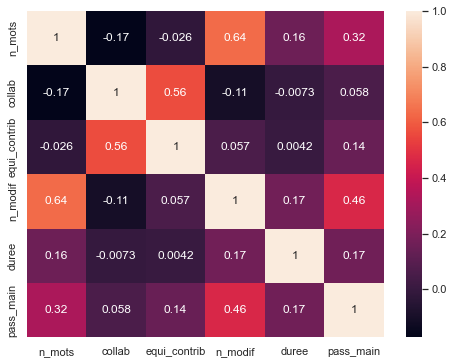

In [7]:
sns.heatmap(X.corr(),annot=True)

In [8]:
data= X.copy()

pt_trans = ["n_modif", "n_mots", "pass_main"]
for _,c in enumerate(pt_trans):
    data.loc[:, c] = pt.fit_transform(np.array(data[c]).reshape(-1, 1))
    

qt_trans = ["duree", "equi_contrib", "collab"]
for _, c in enumerate(qt_trans):
    data.loc[:, c] = qt.fit_transform(np.array(data[c]).reshape(-1, 1))

# scaler = StandardScaler()
# data= pd.DataFrame(scaler.fit_transform(data), columns=data.columns)


In [9]:
data.drop(["n_modif"], axis=1, inplace=True)
data.describe()

,n_mots,collab,equi_contrib,duree,pass_main
count,1.626700e+04,16267.000000,16267.000000,16267.000000,1.626700e+04
mean,-6.988802e-16,-0.163438,0.001862,-0.000041,1.308653e-15
std,1.000031e+00,1.472663,1.009186,1.000155,1.000031e+00
min,-4.249493e+00,-5.199338,-5.199338,-5.199338,-9.076637e-01
25%,-6.468359e-01,-0.674775,-0.674319,-0.674597,-9.076637e-01
50%,-2.880168e-03,-0.000032,0.000296,-0.000175,-9.076637e-01
75%,6.508737e-01,0.674229,0.674337,0.674733,6.067433e-01
max,4.353302e+00,5.199338,5.199338,5.199338,2.043529e+00


<AxesSubplot:>

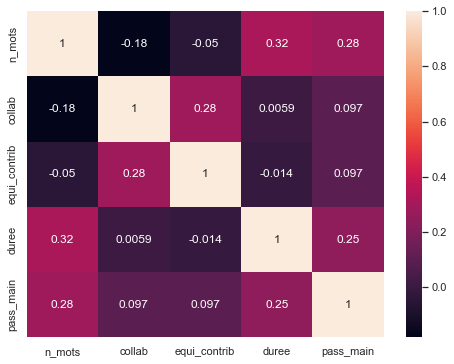

In [10]:
sns.heatmap(data.corr(),annot=True)

<AxesSubplot:>

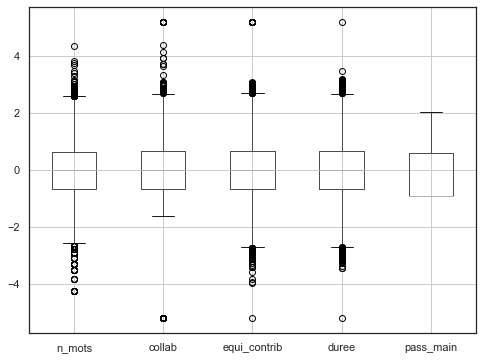

In [11]:
#data.drop(["duree"], axis=1, inplace=True)
data.boxplot()

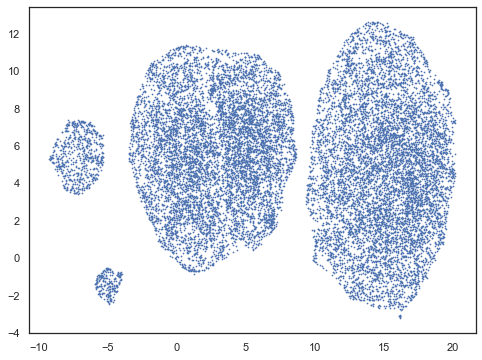

In [12]:
standard_embedding = umap.UMAP(
    random_state=42, min_dist=.5).fit_transform(data)
plt.scatter(standard_embedding[:, 0],
            standard_embedding[:, 1], s=0.5, cmap='Spectral')
plt.show()

In [13]:
clusterable_embedding = umap.UMAP(n_components=2,
    random_state=42, n_neighbors=20, min_dist=0).fit_transform(data)

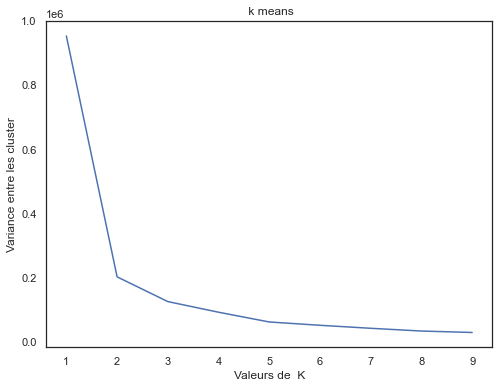

In [14]:
#Trouver le meilleur K
Sum_of_squared_distances = []
K = range(1,10)
for num_clusters in K:
    model = KMeans(n_clusters=num_clusters)
    model.fit(clusterable_embedding)
    Sum_of_squared_distances.append(model.inertia_)
plt.plot(K, Sum_of_squared_distances)
plt.xlabel('Valeurs de  K')
plt.ylabel('Variance entre les cluster')
plt.title(' k means')
plt.show()


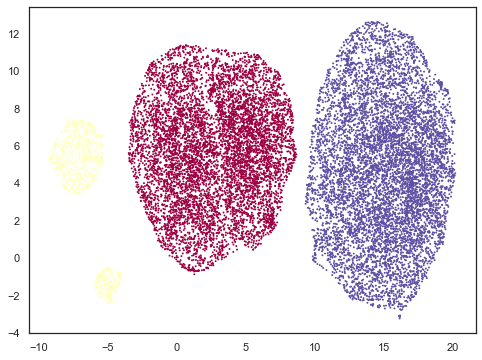

In [19]:
n_clusters = 3
kmeans_labels = KMeans(n_clusters=n_clusters).fit_predict(
    clusterable_embedding)
plt.scatter(standard_embedding[:, 0], standard_embedding[:,
            1], c=kmeans_labels, s=0.8, cmap='Spectral')
plt.show()

In [20]:
gb = X.groupby(kmeans_labels)
result = pd.DataFrame(gb.mean())
result["freq %"] = gb.size() / np.shape(X)[0] * 100
result.append(X.mean(), ignore_index=True)

# La dernière ligne est la moyenne sur tout le dataset 

,n_mots,collab,equi_contrib,n_modif,duree,pass_main,freq %
0,242.459697,0.311363,0.543444,54.472599,417521.280394,3.161213,46.216266
1,136.494700,0.000000,0.670087,25.475854,235525.335689,1.408716,5.219155
2,145.638228,0.310230,0.478485,30.343418,236365.817722,1.000506,48.564579
3,189.908281,0.294563,0.518507,41.240979,320045.242270,2.020409,NaN


* Cluster 0 : grand, forte contribution et collaboration moyenne (entre les deux stratégies séquentielles, sommative et intégrative )
* Cluster 1 : petit, forte contribution et très faible collaboration (Construction séquentielle sommative) 
* Cluster 2 : très petit, forte contribution et forte collaboration (Construction séquentielle intégrative)
* Cluster 3 : très petit faible contribution et faible collaboration (pas de collaboration, le document est rédigé par une minorité)

In [17]:
# pour chaque n_user : nombre n_user dans le cluster / nombre total de n_user
n_users_total = pd.DataFrame([data_full[kmeans_labels == i].groupby(
    "n_users").size() / data_full.groupby("n_users").size() * 100 for i in range(n_clusters)])
n_users_total

n_users,2,3,4,5,6,7,8
0,30.059285,7.978723,2.487562,NaN,NaN,NaN,NaN
1,34.449607,82.947434,94.776119,99.159664,100.0,100.0,100.0
2,29.402339,6.445557,1.492537,0.840336,NaN,NaN,NaN
3,6.088768,2.628285,1.243781,NaN,NaN,NaN,NaN


In [18]:
# pour chaque n_user : nombre n_user dans le cluster / nombre total de n_user dans le cluster)
n_users_cluster = pd.DataFrame([data_full[kmeans_labels == i].groupby(
    "n_users").size() / data_full.groupby(
    kmeans_labels).size()[i] * 100 for i in range(n_clusters)])
n_users_cluster

n_users,2,3,4,5,6,7,8
0,93.403037,6.348021,0.248942,NaN,NaN,NaN,NaN
1,57.196063,35.262038,5.067837,1.569566,0.571961,0.266028,0.066507
2,94.514551,5.305176,0.154520,0.025753,NaN,NaN,NaN
3,89.517079,9.893993,0.588928,NaN,NaN,NaN,NaN
